# Crosswalk

In [1]:
using AutomotiveDrivingModels
using AutoViz

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.5/AutomotiveDrivingModels.ji for module AutomotiveDrivingModels.
INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.5/AutoViz.ji for module AutoViz.


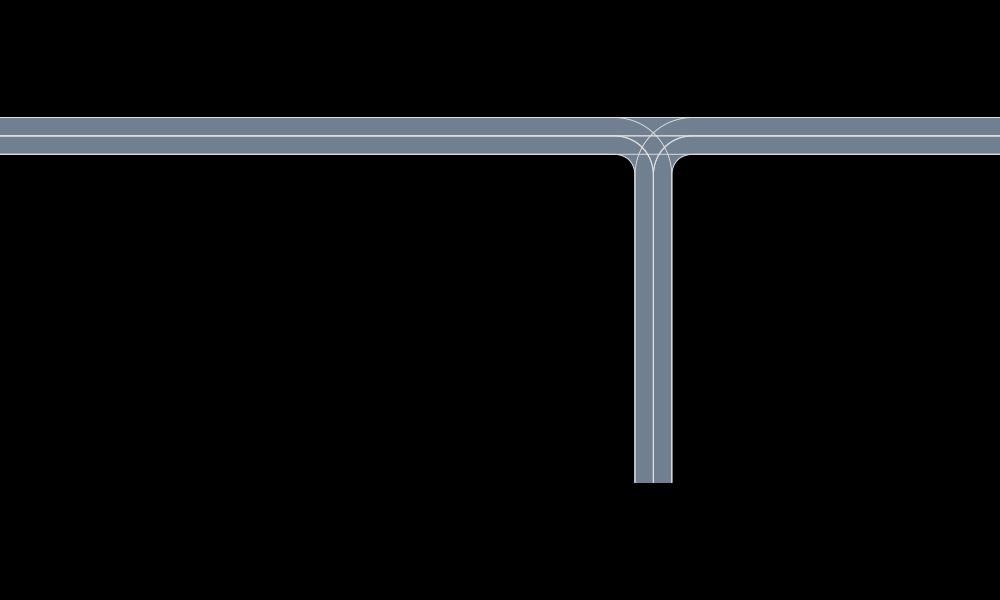

In [2]:
r = 5.0
A = VecSE2(0,DEFAULT_LANE_WIDTH,-π)
B = VecSE2(0,0,0)
C = VecSE2(r,-r,-π/2)
D = VecSE2(r+DEFAULT_LANE_WIDTH,-r,π/2)
E = VecSE2(2r+DEFAULT_LANE_WIDTH,0,0)
F = VecSE2(2r+DEFAULT_LANE_WIDTH,DEFAULT_LANE_WIDTH,-π)

roadway = Roadway()

function append_to_curve!(target::Curve, newstuff::Curve)
    for c in newstuff
        
    end
    return target
end

curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append!(curve, gen_bezier_curve(B, C, 0.6r, 0.6r, 51)[2:end])
append!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50.0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, B+VecE2(-100,0)), convert(VecE2, B), 2)
append!(curve, gen_straight_curve(convert(VecE2, B), convert(VecE2, E), 2)[2:end])
append!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append!(curve, gen_straight_curve(convert(VecE2, F), convert(VecE2, A), 2)[2:end])
append!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, F+VecE2(50,0)), convert(VecE2, F), 2)
append!(curve, gen_bezier_curve(F, C, 0.9r, 0.9r, 51)[2:end])
append!(curve, gen_straight_curve(convert(VecE2, C), convert(VecE2, C+VecE2(0,-50)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append!(curve, gen_bezier_curve(D, E, 0.6r, 0.6r, 51)[2:end])
append!(curve, gen_straight_curve(convert(VecE2, E), convert(VecE2, E+VecE2(50,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

curve = gen_straight_curve(convert(VecE2, D+VecE2(0,-50)), convert(VecE2, D), 2)
append!(curve, gen_bezier_curve(D, A, 0.9r, 0.9r, 51)[2:end])
append!(curve, gen_straight_curve(convert(VecE2, A), convert(VecE2, A+VecE2(-100,0)), 2))
lane = Lane(LaneTag(length(roadway.segments)+1,1), curve)
push!(roadway.segments, RoadSegment(lane.tag.segment, [Lane(lane)]))

cam = FitToContentCamera(0.0)
render(roadway, cam=cam)

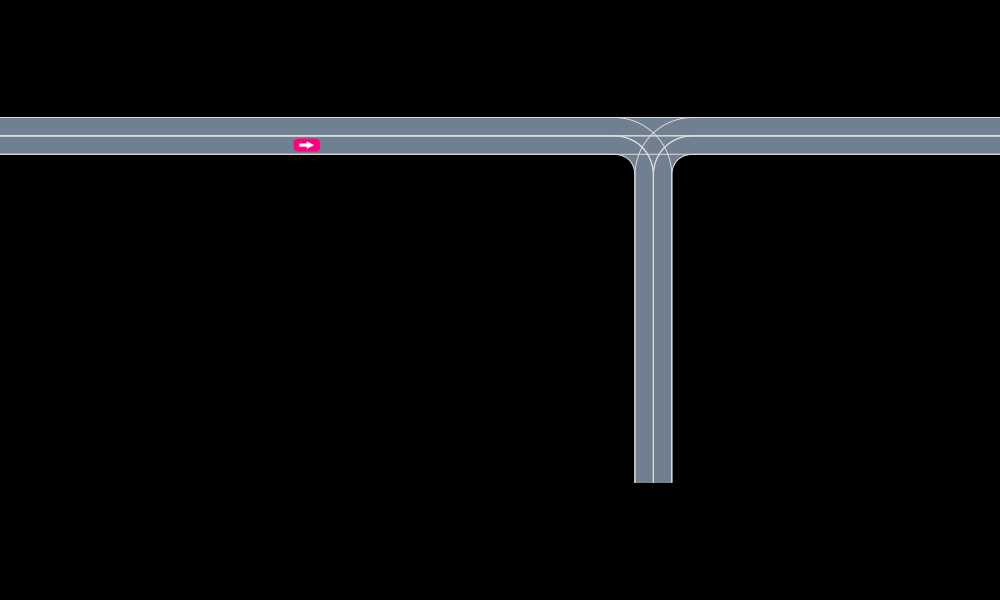

In [3]:
scene = Scene()
push!(scene, Vehicle(VehicleState(B + polar(50.0,-π), roadway, 8.0), VehicleDef(), 1))

render(scene, roadway, cam=cam)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(3, nactions=1),"i",3,"3",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6),Dict(4=>"4",2=>"2",3=>"3",5=>"5",6=>"6",1=>"1")),Any[],Any[],true,"horizontal")

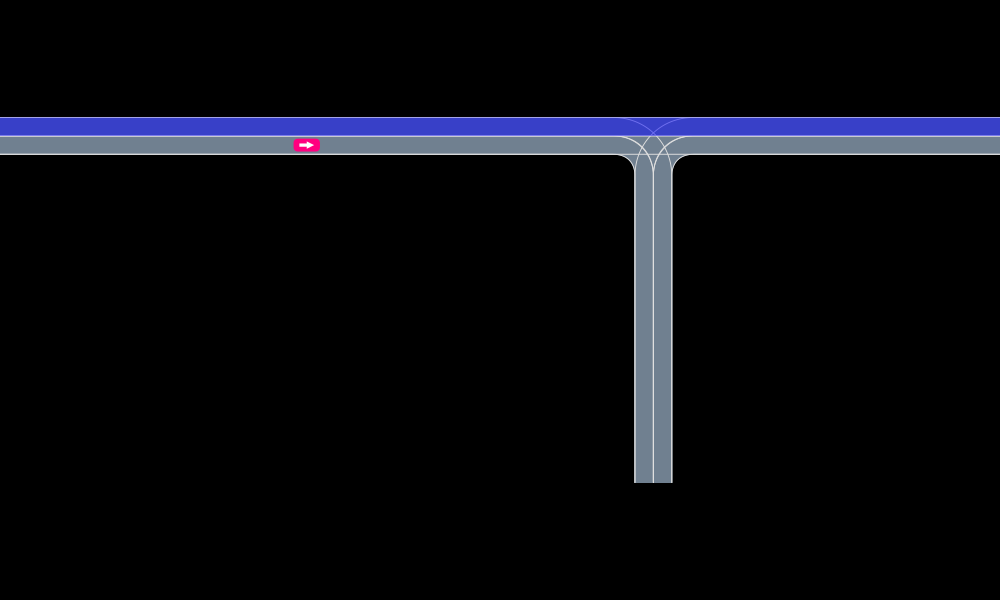

In [4]:
using Interact

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

@manipulate for i in 1 : length(roadway.segments)
    render(scene, roadway, [LaneOverlay(roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=cam)
end

In [5]:
immutable LaneSpecificAccelLatLon
    a_lat::Float64
    a_lon::Float64
end
function AutomotiveDrivingModels.propagate(veh::Vehicle, action::LaneSpecificAccelLatLon, roadway::Roadway, Δt::Float64)
    println("action: ", action)
    println("\tspeed: ", veh.state.v)
    println("\tposF: ", veh.state.posF)
    println("\tposG: ", veh.state.posG)
    lane_tag_orig = veh.state.posF.roadind.tag
    state = propagate(veh, LatLonAccel(action.a_lat, action.a_lon), roadway, Δt)
    println("\tposG: ", state.posG)
    roadproj = proj(state.posG, roadway[lane_tag_orig], roadway, move_along_curves=false)
    retval = VehicleState(Frenet(roadproj, roadway), roadway, state.v)
    println("\tposG: ", retval.posG)
    return retval
end

type CrosswalkDriver <: DriverModel{LaneSpecificAccelLatLon}
    a::LaneSpecificAccelLatLon
end
AutomotiveDrivingModels.get_name(model::CrosswalkDriver) = "CrosswalkDriver"
Base.rand(model::CrosswalkDriver) = model.a

action: LaneSpecificAccelLatLon(0.0,0.0)
	speed: 8.0
	posF: Frenet(RoadIndex({1, 0.500000}, {1, 1}), 50.000, -0.000, 0.000)
	posG: VecSE2({-50.000, -0.000}, 0.000)
a_lat: 0.0  a_lon: 0.0
	Δs: 0.8
	Δt: 0.0
	roadind: RoadIndex({53, 1.000000}, {1, 1})
	posG: VecE2(5.000, -55.000)
	posG: VecSE2({5.000, -55.000}, -1.571)
	posG: VecSE2({5.000, -55.000}, -1.571)
	posG: VecSE2({5.000, -55.000}, -1.571)
action: LaneSpecificAccelLatLon(0.0,0.0)
	speed: 8.0
	posF: Frenet(RoadIndex({53, 1.000000}, {1, 1}), 50.000, -0.000, 0.000)
	posG: VecSE2({5.000, -55.000}, -1.571)
a_lat: 0.0  a_lon: 0.0
	Δs: 0.8
	Δt: 0.0
	roadind: RoadIndex({53, 1.000000}, {1, 1})
	posG: VecE2(5.000, -55.000)
	posG: VecSE2({5.000, -55.000}, -1.571)
	posG: VecSE2({5.000, -55.000}, -1.571)
	posG: VecSE2({5.000, -55.000}, -1.571)
action: LaneSpecificAccelLatLon(0.0,0.0)
	speed: 8.0
	posF: Frenet(RoadIndex({53, 1.000000}, {1, 1}), 50.000, -0.000, 0.000)
	posG: VecSE2({5.000, -55.000}, -1.571)
a_lat: 0.0  a_lon: 0.0
	Δs: 0.8
	Δt: 0

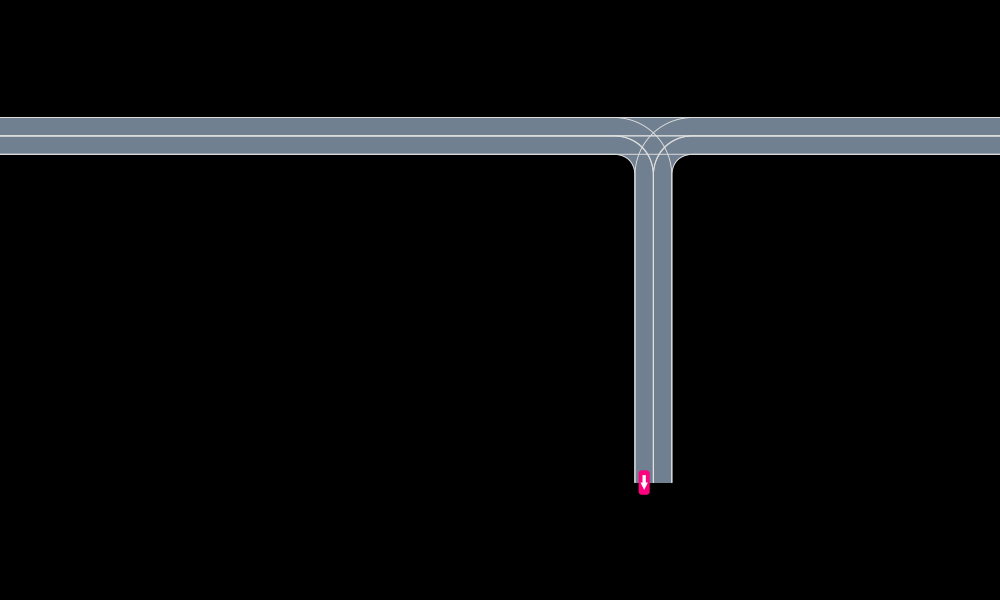

In [6]:
timestep = 0.1

models = Dict{Int, DriverModel}()
models[1] = CrosswalkDriver(LaneSpecificAccelLatLon(0.0,0.0))

nticks = 100
rec = SceneRecord(nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)
render(rec[0], roadway, cam=cam)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(51, nactions=1),"frame_index",51,"51",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

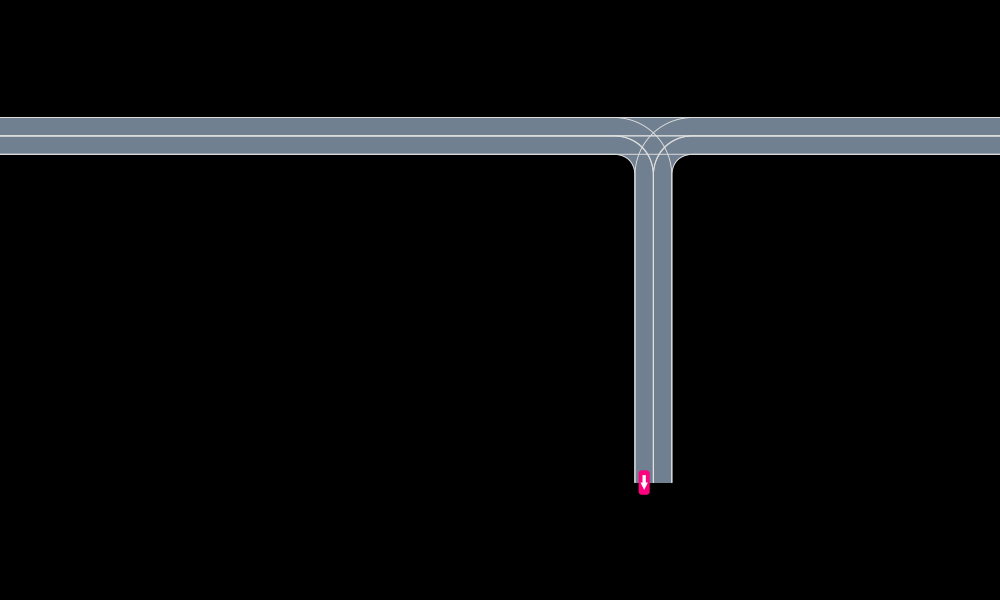

In [7]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam)
end

In [8]:
type Crosswalk
    roadway::Roadway
    crosswalk::Lane
end

In [9]:
const PEDESTRIAN_DEF = VehicleDef(AgentClass.PEDESTRIAN, 1.0, 1.0)

VehicleDef(TRUCK, 1.000, 1.000)